<a href="https://colab.research.google.com/github/DrAlexSanz/NLP-SPEC-C3/blob/main/W4/Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4: Question duplicates
Welcome to the fourth assignment of course 3. In this assignment you will explore Siamese networks applied to natural language processing. You will further explore the fundamentals of Trax and you will be able to implement a more complicated structure using it. By completing this assignment, you will learn how to implement models with different architectures.

### Overview
In this assignment, concretely you will:

* Learn about Siamese networks
* Understand how the triplet loss works
* Understand how to evaluate accuracy
* Use cosine similarity between the model's outputted vectors
* Use the data generator to get batches of questions
* Predict using your own model

By now, you are familiar with trax and know how to make use of classes to define your model. We will start this homework by asking you to preprocess the data the same way you did in the previous assignments. After processing the data you will build a classifier that will allow you to identify whether to questions are the same or not.

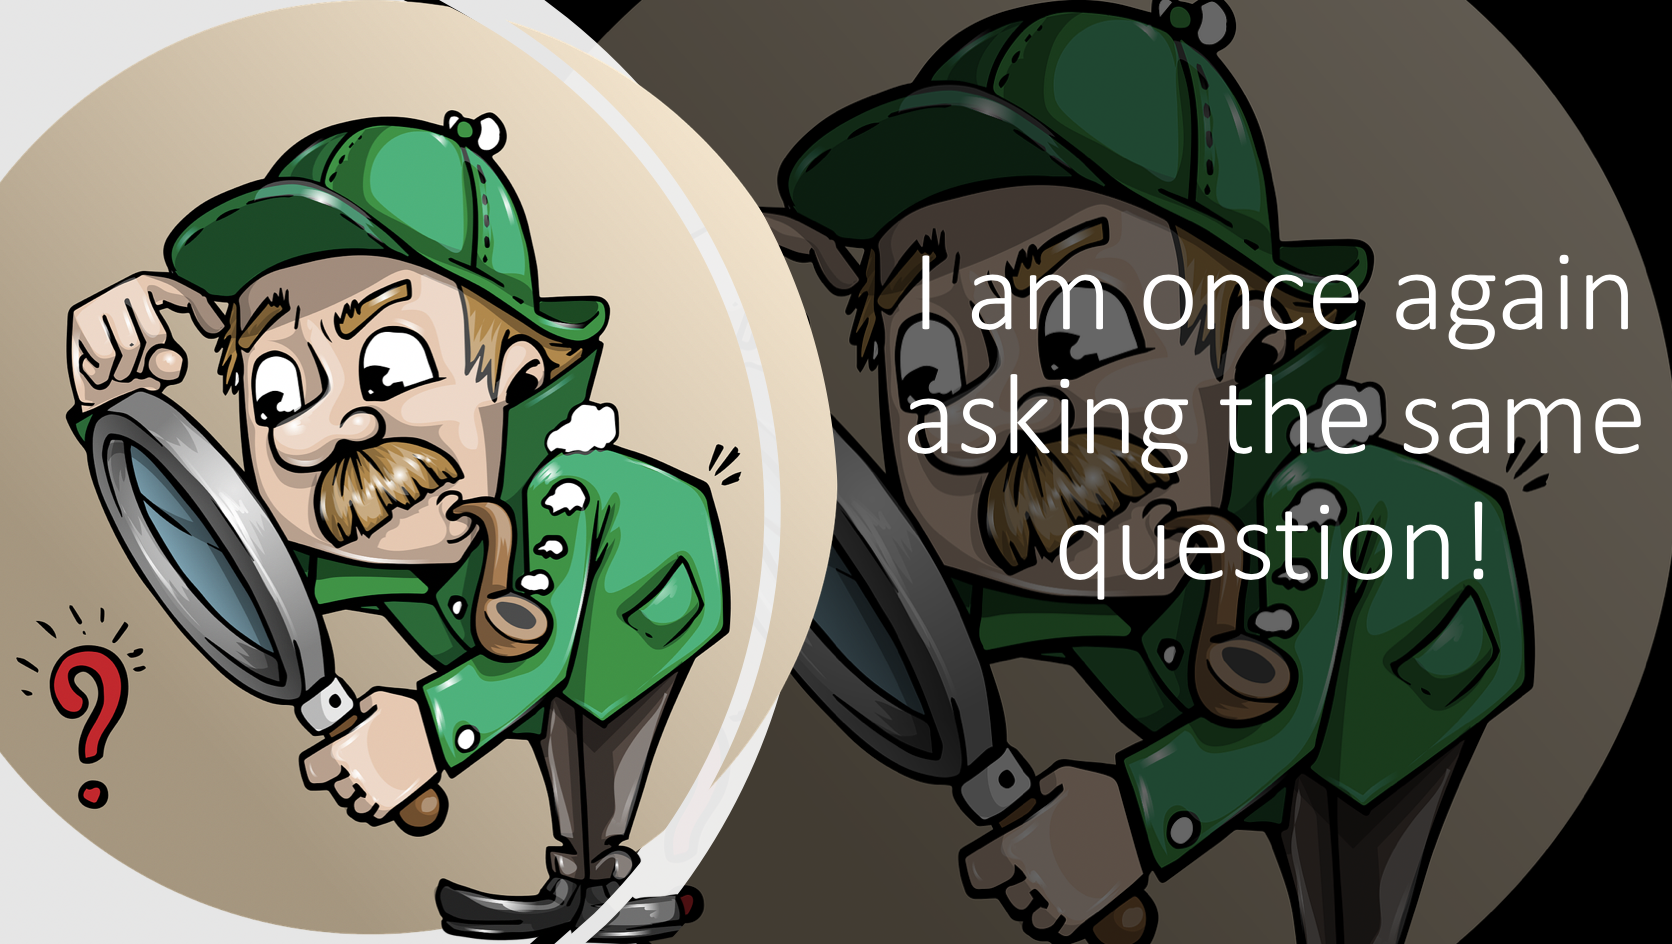

You will process the data first and then pad in a similar way you have done in the previous assignment. Your model will take in the two question embeddings, run them through an LSTM, and then compare the outputs of the two sub networks using cosine similarity. Before taking a deep dive into the model, start by importing the data set.

In [1]:
!pip install trax==1.3.1

import os
import nltk
nltk.download('punkt')
nltk.data.path.append('.')

import trax
from trax import layers as tl
from trax.supervised import training
from trax.fastmath import numpy as fastnp
import numpy as np
import pandas as pd
import random as rnd

from collections import defaultdict

     |████████████████████████████████| 348kB 5.6MB/s 
     |████████████████████████████████| 1.5MB 17.5MB/s 
     |████████████████████████████████| 2.6MB 28.8MB/s 
     |████████████████████████████████| 174kB 43.7MB/s 
     |████████████████████████████████| 5.3MB 35.8MB/s 
     |████████████████████████████████| 368kB 42.7MB/s 
     |████████████████████████████████| 358kB 38.0MB/s 
     |████████████████████████████████| 194kB 44.4MB/s 
     |████████████████████████████████| 983kB 37.2MB/s 
     |████████████████████████████████| 655kB 43.2MB/s 
     |████████████████████████████████| 81kB 7.8MB/s 
     |████████████████████████████████| 348kB 39.9MB/s 
     |████████████████████████████████| 1.4MB 37.5MB/s 
     |████████████████████████████████| 71kB 6.6MB/s 
     |████████████████████████████████| 1.1MB 37.3MB/s 
     |████████████████████████████████| 3.7MB 46.7MB/s 
     |████████████████████████████████| 245kB 35.0MB/s 
     |████████████████████████████████| 51kB 4.7MB/s 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Part 1: Importing the Data

### 1.1 Loading in the data
You will be using the Quora question answer dataset to build a model that could identify similar questions. This is a useful task because you don't want to have several versions of the same question posted. Several times when teaching I end up responding to similar questions on piazza, or on other community forums. This data set has been labeled for you. Run the cell below to import some of the packages you will be using.

In [17]:
% cp "drive/MyDrive/Quora_dataset/questions.csv" "questions.csv"
drive.flush_and_unmount() # Remove the drive, no need to have it here
data = pd.read_csv("questions.csv")
data.head()

cp: cannot stat 'drive/MyDrive/Quora_dataset/questions.csv': No such file or directory
Drive not mounted, so nothing to flush and unmount.


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


We first split the data into a train and test set. The test set will be used later to evaluate our model.

In [18]:
N_train = 300000

N_test = 10*1024

data_train = data[:N_train]
data_test = data[N_train:N_train+N_test]
data_val = data[N_train+N_test:]

del(data) # Free some memory

As explained in the lectures, we select only the question pairs that are duplicate to train the model.
We build two batches as input for the Siamese network and we assume that question $q1_i$ (question $i$ in the first batch) is a duplicate of $q2_i$ (question $i$ in the second batch), but all other questions in the second batch are not duplicates of $q1_i$.
The test set uses the original pairs of questions and the status describing if the questions are duplicates.

In [19]:
td_index = (data_train["is_duplicate"] == 1).to_numpy() # This is a boolean vector
td_index = [i for i, x in enumerate(td_index) if x]

print("Number of duplicate questions", len(td_index))
print("indexes of first 10 duplicate questions", td_index[:10])

Number of duplicate questions 111486
indexes of first 10 duplicate questions [5, 7, 11, 12, 13, 15, 16, 18, 20, 29]


In [20]:
# Check the first duplicate question

print(data_train["question1"][5])
print(data_train["question2"][5])

Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?


In [21]:
Q1_train_words = np.array(data_train["question1"][td_index]) # Name it words to denote that it's an array of words. I don't know who created the naming convention for this one
Q2_train_words = np.array(data_train["question2"][td_index]) # I'm teaching this thing to detect duplicates, I know the label!

Q1_test_words = np.array(data_test["question1"])
Q2_test_words = np.array(data_test["question2"])
y_test = np.array(data_test["is_duplicate"]) # I need labels for test

Above, you have seen that you only took the duplicated questions for training our model.
You did so on purpose, because the data generator will produce batches $([q1_1, q1_2, q1_3, ...]$, $[q2_1, q2_2,q2_3, ...])$ where $q1_i$ and $q2_k$ are duplicate if and only if $i = k$.

In [22]:
print("Training questions\n")

print("Question 1:", Q1_train_words[0])
print("Question 2:", Q2_train_words[0])
print("Question 1:", Q1_train_words[5])
print("Question 2:", Q2_train_words[5])

print("Test questions\n")

print("Question 1:", Q1_test_words[0])
print("Question 1:", Q2_test_words[0])
print("Are the questions above duplicates?", y_test[0])


Training questions

Question 1: Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
Question 2: I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?
Question 1: What would a Trump presidency mean for current international master’s students on an F1 visa?
Question 2: How will a Trump presidency affect the students presently in US or planning to study in US?
Test questions

Question 1: How do I prepare for interviews for cse?
Question 1: What is the best way to prepare for cse?
Are the questions above duplicates? 0


You will now encode each word of the selected duplicate pairs with an index.
Given a question, you can then just encode it as a list of numbers.

First you tokenize the questions using nltk.word_tokenize.
You need a python default dictionary which later, during inference, assigns the values $0$ to all Out Of Vocabulary (OOV) words.
Then you encode each word of the selected duplicate pairs with an index. Given a question, you can then just encode it as a list of numbers.

In [23]:
Q1_train = np.empty_like(Q1_train_words) #Useful method, vector of Nones with dimensions of Q1_train_words
Q2_train = np.empty_like(Q2_train_words)

Q1_test = np.empty_like(Q1_test_words)
Q2_test = np.empty_like(Q2_test_words)

In [24]:
# from collections import defaultdict
vocab = defaultdict(lambda: 0)
vocab["<PAD>"] = 1 # This will be my first token, 0 for OoV words

for idx in range(len(Q1_train_words)):
    Q1_train[idx] = nltk.word_tokenize(Q1_train_words[idx]) # This gives a list of words
    Q2_train[idx] = nltk.word_tokenize(Q2_train_words[idx])
    q = Q1_train[idx] + Q2_train[idx]
    for word in q:
        if word not in vocab:
            vocab[word] = len(vocab) + 1

print("Length of vocabulary is:", len(vocab))

Length of vocabulary is: 36342


In [25]:
print(vocab['<PAD>'])
print(vocab['Astrology']) # First word encountered
print(vocab['Astronomy']) # Not in vocab

1
2
0


In [26]:
for idx in range(len(Q1_test_words)):
    Q1_test[idx] = nltk.word_tokenize(Q1_test_words[idx])
    Q2_test[idx] = nltk.word_tokenize(Q2_test_words[idx])

In [27]:
print("Train set has reduced to:", len(Q1_train))
print("Test set is:", len(Q1_test))

Train set has reduced to: 111486
Test set is: 10240


In [28]:
# Now I have to encode these Q1 and Q2

for i in range(len(Q1_train)):
    Q1_train[i] = [vocab[word] for word in Q1_train[i]]
    Q2_train[i] = [vocab[word] for word in Q2_train[i]]

for i in range(len(Q1_test)):
    Q1_test[i] = [vocab[word] for word in Q1_test[i]]
    Q2_test[i] = [vocab[word] for word in Q2_test[i]]

In [29]:
#Check the result

print("First question in the dataset:", Q1_train_words[0])
print("And encoded is:", Q1_train[0])

First question in the dataset: Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
And encoded is: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
